<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/Sleep-Quality-Based-EEG-Signals/blob/main/4_Sleep_Quality_ML_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Systems for Sleep Quality Assessment Based on EEG Signals

---

* **Author**: Carmen-Theodora Craciun
* **Status**: Done
* **The purpose of this Notebook**: This notebook handles ...
* **Datasets**: [Sleep-EDFX Database](https://www.physionet.org/content/sleep-edfx/1.0.0/) and [University College Dublin Sleep Apnea Database](https://physionet.org/content/ucddb/1.0.0/)
    * Sleep Cassette (SC) - the study on healthy people;
    * Sleep Telemetry (ST) - sleep study in people with difficulty falling asleep. This study was designed to look at the effects of temazepam, a drug with hypnotic effects;
    * UCDDB - patients diagnosed with apnea, who do not suffer from cardiological diseases or autonomic dysfunctions and are not taking medication at the time of registration.
* **Input**:
  * class_distribution.csv
  * results.zip - a compressed archive containing the layered and prepared dataset for training (train, test, val)
    * each file in these folders represents a *processed sleep window* (epoch)
* **Output:**
  * ...

Un LSTM simplu citește doar Trecut -> Viitor. Un Bi-LSTM citește în ambele sensuri simultan:

Senzor 1: Citește de la Epoca 1 la 100.

Senzor 2: Citește de la Epoca 100 la 1.

De ce e util pentru somn? Uneori, medicii decid stadiul curent uitându-se la ce urmează. De exemplu, o tranziție bruscă poate clarifica dacă semnalul actual era un artefact sau o undă reală. Bi-LSTM-ul îi oferă rețelei contextul complet: "Știu ce a fost înainte ȘI știu ce urmează".

#Imports

In [21]:
import os
import numpy as np
import glob
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torchaudio.transforms as T
import torch.optim as optim
import pandas as pd
import gc
import torch.nn.functional as F

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
base_path = '/content/drive/MyDrive/sleep_data'

#Define the dataset

In [4]:
first_file = [f for f in os.listdir(base_path + '/process_dataset/train') if f.endswith('.npz')][0]
full_path = os.path.join(base_path + '/process_dataset/train', first_file)

data = np.load(full_path)
print("Keys from file:", data.files)
print("Shape of the data (x):", data[data.files[0]].shape)
print("Chanles in the file: ",data[data.files[0]].shape[1])
print("Shape of the labels (y):", data[data.files[1]].shape)

num_epochs = data[data.files[1]].shape[0]
total_seconds = num_epochs * 30
total_hours = total_seconds / 3600
print(f"Hours of sleep in this file: {total_hours:.2f} hours")

Keys from file: ['x', 'y']
Shape of the data (x): (1092, 2, 3000)
Chanles in the file:  2
Shape of the labels (y): (1092,)
Hours of sleep in this file: 9.10 hours


In [24]:
def get_loaders(base_path, batch_size=32, force_process=False):
    """
    Loads sleep stage data from .npz files, handles channel dimension mismatches
    (Sleep-EDF vs UCD), and returns PyTorch DataLoaders.

    Optimized for low-memory environments by pre-allocating tensors.

    Paarameters:
        - base_path (str): Path to the parent folder containing 'process_dataset' and 'bi_lstm'.
        - batch_size (int): Batch size for the DataLoader.
        - force_process (bool): If True, ignores existing .pt cache and re-processes .npz files.

    Returns:
        dict: A dictionary containing 'train', 'val', and 'test' DataLoaders.
    """
    loaders = {}
    modes = ['train', 'val', 'test']

    # Cache directory for processed tensors
    cache_dir = os.path.join(base_path, "bi_lstm")
    os.makedirs(cache_dir, exist_ok=True)

    print(f"[INFO] Storage path: {cache_dir}")

    for mode in modes:
        cache_file = os.path.join(cache_dir, f"{mode}_processed.pt")

        # Force garbage collection to free memory from previous mode
        gc.collect()

        # --- OPTION 1: Load from existing cached .pt file ---
        if os.path.exists(cache_file) and not force_process:
            print(f"[{mode.upper()}] Loading cached data from: {os.path.basename(cache_file)}")
            saved_data = torch.load(cache_file)
            dataset = TensorDataset(saved_data['x'], saved_data['y'])
            shuffle = True if mode == 'train' else False
            loaders[mode] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

            # Cleanup
            del saved_data
            gc.collect()

        # --- OPTION 2: Process .npz files from scratch ---
        else:
            print(f"[{mode.upper()}] Processing .npz files...")
            source_folder = os.path.join(base_path, 'process_dataset', mode)
            file_list = glob.glob(os.path.join(source_folder, "*.npz"))

            if not file_list:
                print(f"[{mode.upper()}] Warning: No files found in {source_folder}")
                continue

            # Step 1: Scan files to calculate total epochs (RAM Optimization)
            total_epochs = 0
            valid_files = []

            for f_path in file_list:
                try:
                    # mmap_mode='r' reads only metadata, not the full array
                    with np.load(f_path, mmap_mode='r') as f:
                        if 'y' in f:
                            total_epochs += f['y'].shape[0]
                            valid_files.append(f_path)
                except Exception:
                    continue

            print(f"   -> Found {total_epochs} epochs. Allocating memory...")

            # Step 2: Pre-allocate Tensors
            # Shape: (Total_Epochs, 3000, 1)
            X_all = torch.zeros(total_epochs, 3000, 1, dtype=torch.float32)
            y_all = torch.zeros(total_epochs, dtype=torch.long)

            # Step 3: Load and fill data
            current_idx = 0
            EXPECTED_LEN = 3000

            for i, f_path in enumerate(valid_files):
                # Optional: Simple progress log every 100 files
                if i % 100 == 0:
                    print(f"   -> Loading file {i}/{len(valid_files)}...")

                try:
                    with np.load(f_path) as f:
                        raw_x = f['x']
                        raw_y = f['y']

                    # --- Handle Dimension Mismatch (UCD vs Sleep-EDF) ---

                    # Case UCD: (Batch, 3000, 1) -> Take last axis
                    if raw_x.ndim == 3 and raw_x.shape[2] == 1:
                        x_extracted = raw_x[:, :, 0]

                    # Case Sleep-EDF: (Batch, 2, 3000) -> Take first channel (Index 0)
                    elif raw_x.ndim == 3 and raw_x.shape[1] >= 1:
                        x_extracted = raw_x[:, 0, :]

                    # Case already flat: (Batch, 3000)
                    elif raw_x.ndim == 2:
                        x_extracted = raw_x

                    else:
                        continue # Skip unknown shapes

                    # Validate Signal Length
                    if x_extracted.shape[1] != EXPECTED_LEN:
                        continue

                    # Insert into pre-allocated tensor
                    num_samples = len(raw_y)
                    if current_idx + num_samples <= total_epochs:
                        X_all[current_idx : current_idx + num_samples, :, 0] = torch.from_numpy(x_extracted)
                        y_all[current_idx : current_idx + num_samples] = torch.from_numpy(raw_y)
                        current_idx += num_samples

                    # Immediate cleanup
                    del raw_x, raw_y, x_extracted

                except Exception as e:
                    print(f"   [Error] Skipping {os.path.basename(f_path)}: {e}")

            # Resize tensors if some files were skipped
            if current_idx < total_epochs:
                X_all = X_all[:current_idx]
                y_all = y_all[:current_idx]

            # Save to disk
            print(f"   -> Saving {os.path.basename(cache_file)}...")
            torch.save({'x': X_all, 'y': y_all}, cache_file)

            # Create Loader
            dataset = TensorDataset(X_all, y_all)
            shuffle = True if mode == 'train' else False
            loaders[mode] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

            # Final cleanup
            del X_all, y_all
            gc.collect()

    return loaders

loader = get_loaders(base_path)

[INFO] Storage path: /content/drive/MyDrive/sleep_data/bi_lstm
[TRAIN] Loading cached data from: train_processed.pt
[VAL] Loading cached data from: val_processed.pt
[TEST] Loading cached data from: test_processed.pt


#Generic functions

In [15]:
# 1. Funcția de antrenare (Generică)
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# 2. Funcția de Evaluare (Generică)
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return total_loss / len(loader), accuracy, all_labels, all_preds

# 3. Funcția Experiment (ACUM SALVEAZĂ MODELUL)
def run_experiment(model, loader, criterion, optimizer, epochs, device, model_name):
    """
    Antrenează modelul și salvează cea mai bună versiune în 'model_name'.
    """
    print(f"--- Start Training: {model_name} ---")
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # A. Antrenare
        train_loss = train_one_epoch(model, loader['train'], optimizer, criterion, device)

        # B. Validare
        val_loss, val_acc, _, _ = evaluate_model(model, loader['val'], criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        saved_msg = ""
        # C. Salvare (Logic)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)
            saved_msg = "-> SAVED"

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% {saved_msg}")

    return history

# 4. Matricea de Confuzie
def plot_confusion_matrix(y_true, y_pred, classes=['Wake', 'N1', 'N2', 'N3', 'REM']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Model prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print("\n--- Classification report ---")
    print(classification_report(y_true, y_pred, target_names=classes))

#Weights

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculăm greutățile pentru clasele dezechilibrate
class_distribution = pd.read_csv(base_path + '/class_distribution.csv')
counts = list(class_distribution['Count'])
weights = [np.sqrt(sum(counts) / c) for c in counts] # Radical = Soft Weights
weights_tensor = torch.tensor(weights, dtype=torch.float32)
weights_tensor = weights_tensor / weights_tensor.sum()
weights_tensor = weights_tensor.to(device)

print(f"Weights: {weights_tensor}")
crit_weighted = nn.CrossEntropyLoss(weight=weights_tensor)

Weights: tensor([0.1738, 0.2427, 0.1248, 0.2568, 0.2019])


#The models

---

Chronological list of attempts, problems encountered:

1. Baseline Model: Simple Bi-LSTM
* A simple recurrent network (Bi-Directional LSTM) applied directly to the spectrogram, without extracting complex features.
* Role: Established a benchmark (~74%). Demonstrated that sequentiality (time) is important, but struggled to extract complex features from the noise of apnea patients.
* Problem:
* The LSTM saw the spectrogram as a time series, but did not understand frequency relationships.
* Overfitting quickly, the model memorized noise from the training data.

2. CRNN Architecture (CNN + LSTM)
* We added convolutional layers (CNN) to extract visual features from the spectrogram, followed by LSTM.
* We replaced Mean Pooling with an Attention mechanism, allowing the model to focus on the relevant seconds in the 30s of an epoch (e.g. to detect an isolated K-complex).
* Problem:
* Although the overall accuracy increased to ~72%, the Recall on the N1 stage was almost 0%. The model only predicted the majority class (N2) to minimize its error.
* Difficulty distinguishing Wake vs N1: The two stages are very similar spectrally, and the simple CNN did not find the fine differences.

3. ResNet "Lite" & Focal Loss
* We needed a deep model, but CPU processing was too slow.
* We created a CPU-optimized ResNet Lite variant (with aggressive strides and reduced channels).
* Problem
* N1: The model ignored the N1 class (transition stage).
* We introduced Focal Loss – a loss function that punishes the model harder when it gets difficult classes wrong, forcing it to learn N1 (Recall increased from 10% to 46%).

5. Stabilization: Label Smoothing & Dropout
* To prevent Overfitting we applied:
* Label Smoothing (0.1): We asked the model to be only 90% confident in its predictions, which helped enormously in generalizing to new apnea patients.
* Dropout (0.5): Randomly deactivating neurons to force the model to learn robust features.

7. The final solution: Heterogeneous Ensemble
* We combined 3 fundamentally different models:
* BiLSTM: Expert in temporal sequences.
* CRNN: Expert in visual patterns (spectrograms).
* ResNet: Expert in deep/abstract features.
* Result: A final accuracy of 76.62% on an extremely difficult dataset (Apnea + Healthy), with correct detection of sleep architecture.

##Baseline BiLSTM

Running V1: BiLSTM Baseline
--- Start Training: model_v1_baseline.pt ---
Epoch 1/15 | Train Loss: 0.7695 | Val Loss: 0.7473 | Val Acc: 71.38% -> SAVED
Epoch 2/15 | Train Loss: 0.6751 | Val Loss: 0.7309 | Val Acc: 70.95% 
Epoch 3/15 | Train Loss: 0.6452 | Val Loss: 0.7152 | Val Acc: 73.05% -> SAVED
Epoch 4/15 | Train Loss: 0.6260 | Val Loss: 0.7154 | Val Acc: 72.33% 
Epoch 5/15 | Train Loss: 0.6106 | Val Loss: 0.7067 | Val Acc: 73.49% -> SAVED
Epoch 6/15 | Train Loss: 0.5975 | Val Loss: 0.6664 | Val Acc: 74.72% -> SAVED
Epoch 7/15 | Train Loss: 0.5850 | Val Loss: 0.6696 | Val Acc: 74.98% -> SAVED
Epoch 8/15 | Train Loss: 0.5756 | Val Loss: 0.6677 | Val Acc: 75.25% -> SAVED
Epoch 9/15 | Train Loss: 0.5660 | Val Loss: 0.6629 | Val Acc: 74.57% 
Epoch 10/15 | Train Loss: 0.5568 | Val Loss: 0.6703 | Val Acc: 74.89% 
Epoch 11/15 | Train Loss: 0.5498 | Val Loss: 0.6699 | Val Acc: 73.87% 
Epoch 12/15 | Train Loss: 0.5420 | Val Loss: 0.6920 | Val Acc: 73.33% 
Epoch 13/15 | Train Loss: 0.5347 | V

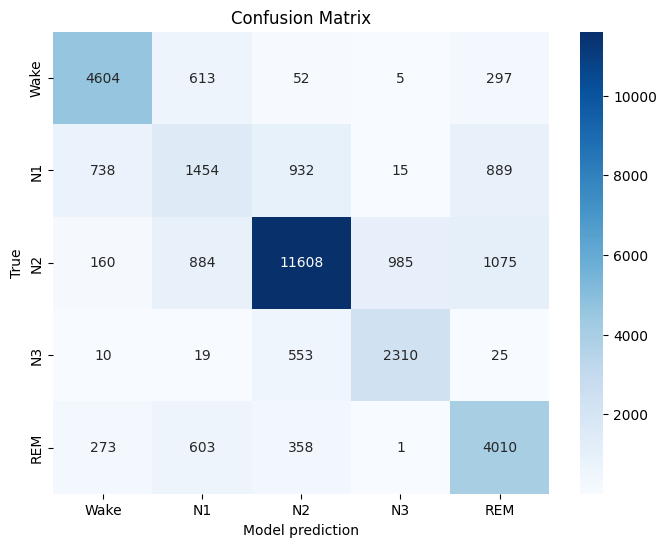


--- Classification report ---
              precision    recall  f1-score   support

        Wake       0.80      0.83      0.81      5571
          N1       0.41      0.36      0.38      4028
          N2       0.86      0.79      0.82     14712
          N3       0.70      0.79      0.74      2917
         REM       0.64      0.76      0.69      5245

    accuracy                           0.74     32473
   macro avg       0.68      0.71      0.69     32473
weighted avg       0.74      0.74      0.74     32473



In [18]:
class BiLSTMSleep(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        # Normalizare
        self.norm = nn.InstanceNorm1d(1, affine=True)
        self.spectrogram = T.Spectrogram(n_fft=128, hop_length=64)
        # Input 65 freq bins
        self.lstm = nn.LSTM(input_size=65, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 5)

    def forward(self, x):
        # x: (Batch, 3000, 1) -> Permute -> Norm -> Spectrogram
        x = x.permute(0, 2, 1) # (Batch, 1, 3000)
        x = self.norm(x)
        x = x.squeeze(1)       # (Batch, 3000)

        x = self.spectrogram(x) # (Batch, 65, Time)
        x = x.permute(0, 2, 1)  # (Batch, Time, 65) pt LSTM

        out, _ = self.lstm(x)
        out = torch.mean(out, dim=1)
        return self.fc(out)

print("Running V1: BiLSTM Baseline")
model_v1 = BiLSTMSleep(hidden_size=64).to(device)
opt_v1 = optim.Adam(model_v1.parameters(), lr=0.001)

run_experiment(model_v1, loader, crit_weighted, opt_v1, epochs=15, device=device, model_name="model_v1_baseline.pt")

model_v1.load_state_dict(torch.load("model_v1_baseline.pt"))
_, test_acc, true_l, pred_l = evaluate_model(model_v1, loader['test'], crit_weighted, device)
print(f"Test Accuracy: {test_acc:.2f}%")
plot_confusion_matrix(true_l, pred_l)

##CRNN

Running V2: CRNN Tuned
--- Start Training: model_v2_crnn.pt ---
Epoch 1/20 | Train Loss: 0.8126 | Val Loss: 0.7228 | Val Acc: 72.97% -> SAVED
Epoch 2/20 | Train Loss: 0.7304 | Val Loss: 0.7225 | Val Acc: 71.81% 
Epoch 3/20 | Train Loss: 0.7038 | Val Loss: 0.7265 | Val Acc: 72.45% 
Epoch 4/20 | Train Loss: 0.6875 | Val Loss: 0.7111 | Val Acc: 72.76% 
Epoch 5/20 | Train Loss: 0.6758 | Val Loss: 0.7423 | Val Acc: 71.60% 
Epoch 6/20 | Train Loss: 0.6653 | Val Loss: 0.6923 | Val Acc: 73.63% -> SAVED
Epoch 7/20 | Train Loss: 0.6533 | Val Loss: 0.6849 | Val Acc: 73.98% -> SAVED
Epoch 8/20 | Train Loss: 0.6463 | Val Loss: 0.7627 | Val Acc: 70.76% 
Epoch 9/20 | Train Loss: 0.6420 | Val Loss: 0.6908 | Val Acc: 73.19% 
Epoch 10/20 | Train Loss: 0.6361 | Val Loss: 0.6784 | Val Acc: 73.91% 
Epoch 11/20 | Train Loss: 0.6279 | Val Loss: 0.7347 | Val Acc: 73.48% 
Epoch 12/20 | Train Loss: 0.6250 | Val Loss: 0.6997 | Val Acc: 72.94% 
Epoch 13/20 | Train Loss: 0.6196 | Val Loss: 0.7564 | Val Acc: 71.10%

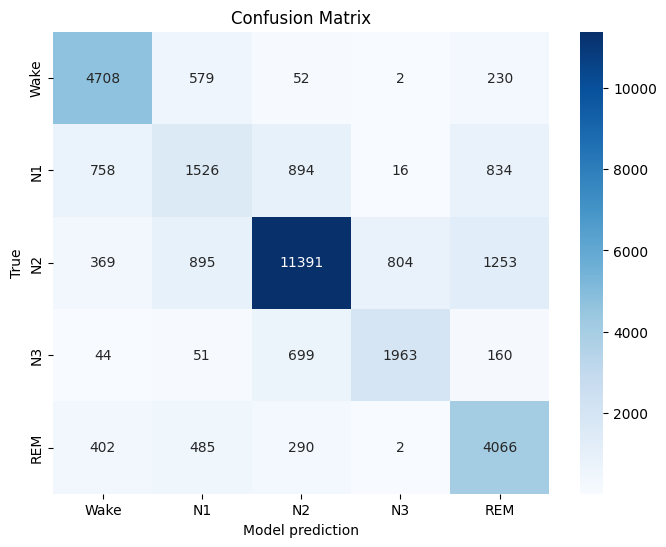


--- Classification report ---
              precision    recall  f1-score   support

        Wake       0.75      0.85      0.79      5571
          N1       0.43      0.38      0.40      4028
          N2       0.85      0.77      0.81     14712
          N3       0.70      0.67      0.69      2917
         REM       0.62      0.78      0.69      5245

    accuracy                           0.73     32473
   macro avg       0.67      0.69      0.68     32473
weighted avg       0.73      0.73      0.73     32473



In [19]:
class CRNNSleep(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.norm = nn.InstanceNorm1d(1, affine=True)
        self.spectrogram = T.Spectrogram(n_fft=128, hop_length=64)

        self.cnn = nn.Sequential(
            nn.Conv1d(65, 64, kernel_size=3, padding=1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(0.3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(0.3)
        )

        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(hidden_size * 2, 5))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.norm(x)
        x = x.squeeze(1)

        x = self.spectrogram(x) # (Batch, 65, Time)
        x = self.cnn(x)         # (Batch, 128, Time_Red)

        x = x.permute(0, 2, 1)  # (Batch, Time_Red, 128)
        out, _ = self.lstm(x)

        # Attention
        attn_weights = torch.softmax(self.attention(out), dim=1)
        out = torch.sum(out * attn_weights, dim=1)

        return self.fc(out)


print("Running V2: CRNN Tuned")
model_v2 = CRNNSleep(hidden_size=128).to(device)
opt_v2 = optim.Adam(model_v2.parameters(), lr=0.001)

run_experiment(model_v2, loader, crit_weighted, opt_v2, epochs=20, device=device, model_name="model_v2_crnn.pt")

model_v2.load_state_dict(torch.load("model_v2_crnn.pt"))
_, test_acc, true_l, pred_l = evaluate_model(model_v2, loader['test'], crit_weighted, device)
print(f"Test Accuracy: {test_acc:.2f}%")
plot_confusion_matrix(true_l, pred_l)

##AttentiveResNet1D

--- Start Training: model_v3_lite.pt ---
Epoch 1/10 | Train Loss: 0.7237 | Val Loss: 0.7208 | Val Acc: 70.19% -> SAVED
Epoch 2/10 | Train Loss: 0.6402 | Val Loss: 0.6934 | Val Acc: 74.07% -> SAVED
Epoch 3/10 | Train Loss: 0.6036 | Val Loss: 0.6794 | Val Acc: 75.16% -> SAVED
Epoch 4/10 | Train Loss: 0.5799 | Val Loss: 0.6636 | Val Acc: 73.98% 
Epoch 5/10 | Train Loss: 0.5618 | Val Loss: 0.7111 | Val Acc: 72.85% 
Epoch 6/10 | Train Loss: 0.5457 | Val Loss: 0.6555 | Val Acc: 74.49% 
Epoch 7/10 | Train Loss: 0.5335 | Val Loss: 0.6575 | Val Acc: 74.81% 
Epoch 8/10 | Train Loss: 0.5232 | Val Loss: 0.6878 | Val Acc: 73.70% 
Epoch 9/10 | Train Loss: 0.5107 | Val Loss: 0.6491 | Val Acc: 75.35% -> SAVED
Epoch 10/10 | Train Loss: 0.4986 | Val Loss: 0.6952 | Val Acc: 74.03% 

--- Test Model V3 Lite ---
Test Accuracy: 75.00%


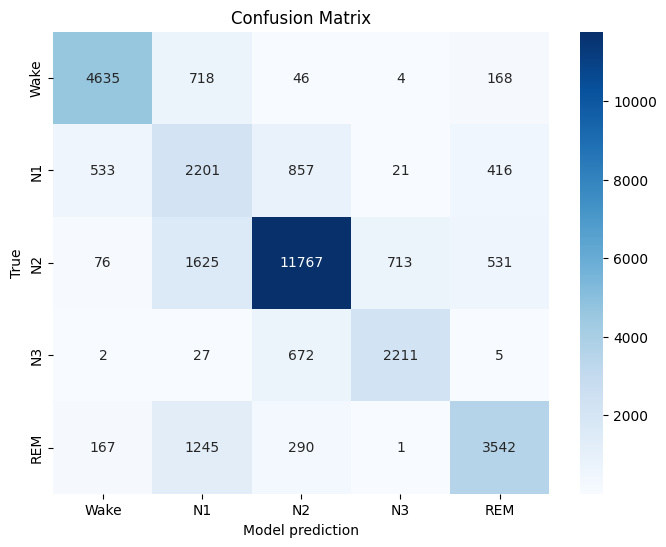


--- Classification report ---
              precision    recall  f1-score   support

        Wake       0.86      0.83      0.84      5571
          N1       0.38      0.55      0.45      4028
          N2       0.86      0.80      0.83     14712
          N3       0.75      0.76      0.75      2917
         REM       0.76      0.68      0.72      5245

    accuracy                           0.75     32473
   macro avg       0.72      0.72      0.72     32473
weighted avg       0.77      0.75      0.76     32473



In [8]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class ResBlockLite(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockLite, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class AttentiveResNet1D_Lite(nn.Module):
    def __init__(self, num_classes=5):
        super(AttentiveResNet1D_Lite, self).__init__()

        # 1. Normalizare (Critică pt UCD vs SC)
        self.norm = nn.InstanceNorm1d(1, affine=True)

        # 2. Compresie Inițială Agresivă (Stride=4)
        # Input: 3000 -> Output: 750. Viteză 4x mai mare.
        self.initial_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=11, stride=4, padding=5, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # 3. Arhitectură ușoară (16 -> 32 -> 64 -> 128)
        self.layer1 = self._make_layer(16, 32, blocks=1, stride=1)
        self.layer2 = self._make_layer(32, 64, blocks=1, stride=2)
        self.layer3 = self._make_layer(64, 128, blocks=1, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResBlockLite(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResBlockLite(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (Batch, 3000, 1) -> Permutăm pt Conv1d (Batch, 1, 3000)
        x = x.permute(0, 2, 1)
        x = self.norm(x)

        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

model_v3 = AttentiveResNet1D_Lite(num_classes=5).to(device)

if 'crit_weighted' not in locals():
    crit_weighted = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_v3.parameters(), lr=0.001)

history = run_experiment(
    model=model_v3,
    loader=loader,
    criterion=crit_weighted,
    optimizer=optimizer,
    epochs=10,
    device=device,
    model_name="model_v3_lite.pt"
)

print("\n--- Test Model V3 Lite ---")
model_v3.load_state_dict(torch.load("model_v3_lite.pt"))

_, test_acc, t_l, p_l = evaluate_model(model_v3, loader['test'], crit_weighted, device)
print(f"Test Accuracy: {test_acc:.2f}%")
plot_confusion_matrix(t_l, p_l)

##Esemble model

Model 1 (BiLSTM) uploaded.
Model 2 (CRNN) uploaded.
Model 3 (ResNet Robust) uploaded.

Statrt ensemble prediction

ENSEMBLE ACCURACY: 76.62%


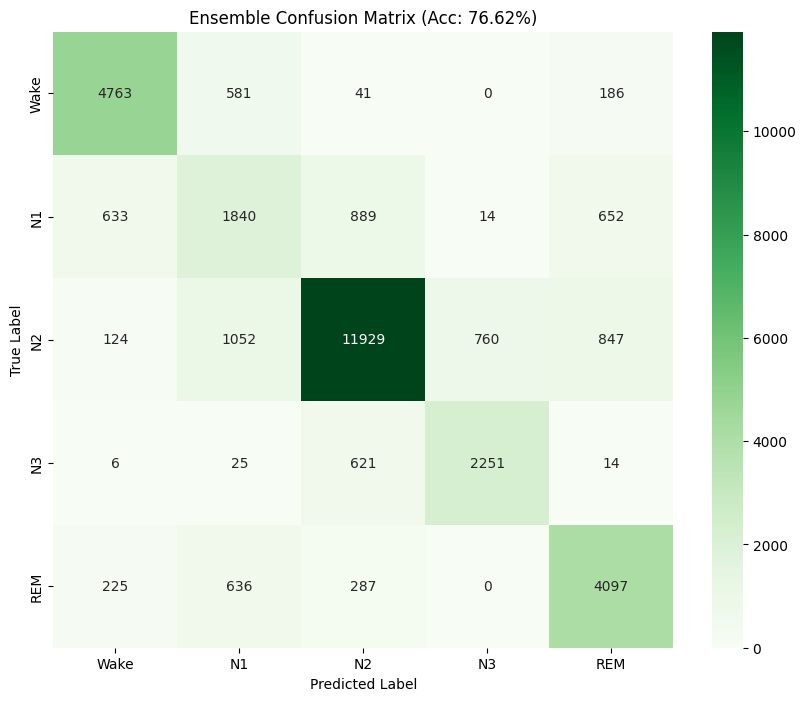

              precision    recall  f1-score   support

        Wake       0.83      0.85      0.84      5571
          N1       0.45      0.46      0.45      4028
          N2       0.87      0.81      0.84     14712
          N3       0.74      0.77      0.76      2917
         REM       0.71      0.78      0.74      5245

    accuracy                           0.77     32473
   macro avg       0.72      0.74      0.73     32473
weighted avg       0.77      0.77      0.77     32473



In [28]:
model1 = BiLSTMSleep(hidden_size=64).to(device)
model2 = CRNNSleep(hidden_size=128).to(device)
model3 = AttentiveResNet1D_Lite(num_classes=5).to(device)

models = []

try:
    model1.load_state_dict(torch.load("model_v1_baseline.pt", map_location=device))
    model1.eval()
    models.append(model1)
    print("Model 1 (BiLSTM) uploaded.")
except:
    print("Model 1 is not uploaded.")

try:
    model2.load_state_dict(torch.load("model_v2_crnn.pt", map_location=device))
    model2.eval()
    models.append(model2)
    print("Model 2 (CRNN) uploaded.")
except:
    print("Model 2 is not uploaded.")

try:
    model3.load_state_dict(torch.load("model_v3_lite.pt", map_location=device))
    model3.eval()
    models.append(model3)
    print("Model 3 (ResNet Robust) uploaded.")
except:
    print("Model 3 is not uploaded.")

if not models:
    print("No model uploaded.")
    exit()

# 3. Bucla de Predicție ENSEMBLE
print("\nStart ensemble prediction")
all_preds = []
all_labels = []

# Ponderi pentru vot (Dăm puțin mai puțină încredere lui ResNet că e antrenat puțin)
# [BiLSTM, CRNN, ResNet]
# Dacă lipsește vreun model, codul se adaptează automat, dar presupunem că sunt toate 3.
ensemble_weights = [1.0, 1.0, 0.8]

with torch.no_grad():
    for inputs, labels in loader['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Colectăm logit-urile (scorurile brute) de la fiecare model
        outputs = []

        if len(models) >= 1: outputs.append(models[0](inputs) * ensemble_weights[0])
        if len(models) >= 2: outputs.append(models[1](inputs) * ensemble_weights[1])
        if len(models) >= 3: outputs.append(models[2](inputs) * ensemble_weights[2])

        # Facem suma scorurilor (Soft Voting)
        final_out = torch.stack(outputs).sum(dim=0)

        # Decizia finală
        _, predicted = torch.max(final_out, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Raport Final
acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nENSEMBLE ACCURACY: {acc:.2f}%")

classes = ['Wake', 'N1', 'N2', 'N3', 'REM']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title(f'Ensemble Confusion Matrix (Acc: {acc:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

#Calculate the quality of sleep


      SLEEP ARCHITECTURE REPORT      
Stage      | Real (%)   | Predicted (%) | Diff      
----------------------------------------------
Wake       | 17.16      | 17.71      | +0.55
N1         | 12.40      | 12.73      | +0.33
N2         | 45.31      | 42.40      | -2.91
N3         | 8.98       | 9.32       | +0.33
REM        | 16.15      | 17.85      | +1.70
----------------------------------------------
Restorative (N3+REM): Real 25.13% vs Pred 27.16%



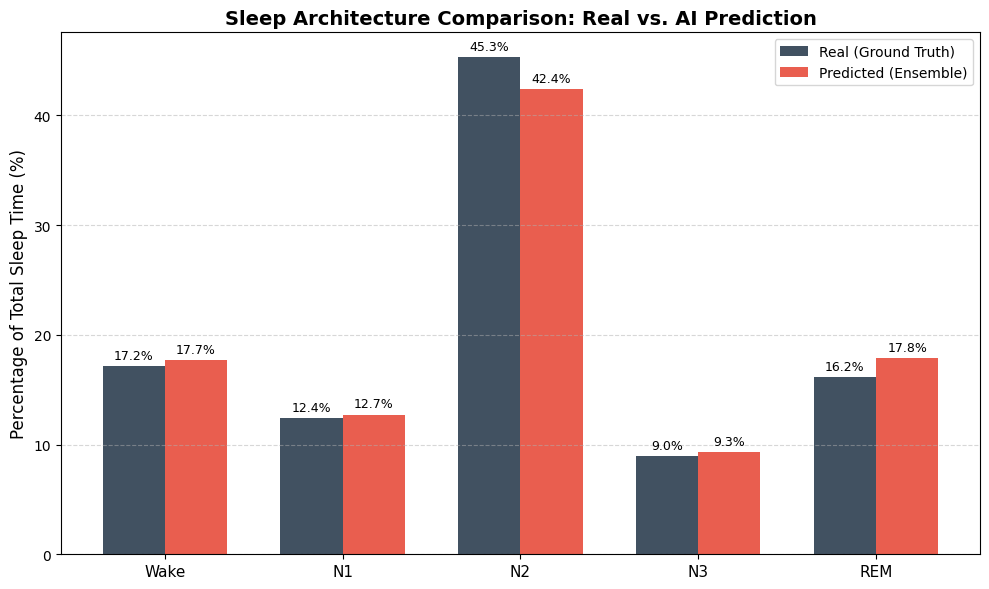

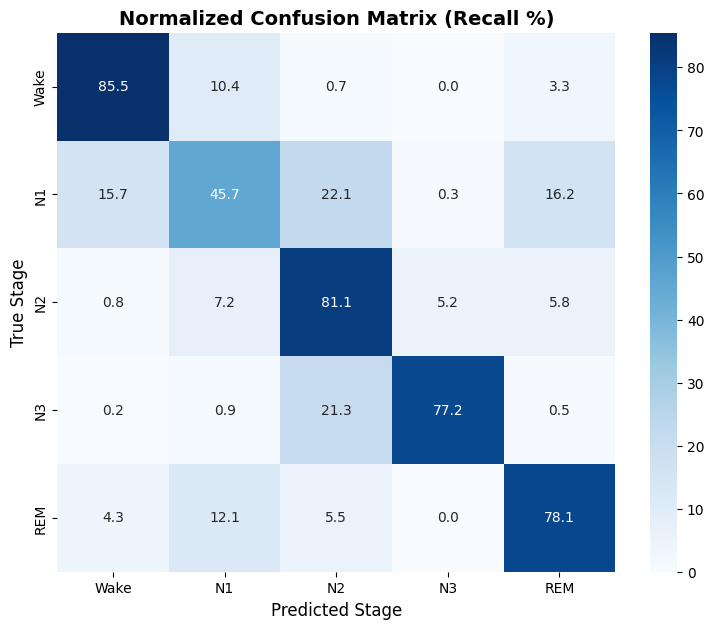

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- 1. SLEEP QUALITY ANALYSIS FUNCTION ---
def analyze_sleep_architecture(true_labels, pred_labels, class_names):
    """
    Analyzes and compares the Sleep Architecture (Distribution of stages)
    between Ground Truth (Real) and Model Predictions.
    """

    # 1. Calculate Percentages per Stage
    total_epochs = len(true_labels)
    real_counts = [np.sum(np.array(true_labels) == i) for i in range(len(class_names))]
    pred_counts = [np.sum(np.array(pred_labels) == i) for i in range(len(class_names))]

    real_pct = [c / total_epochs * 100 for c in real_counts]
    pred_pct = [c / total_epochs * 100 for c in pred_counts]

    # 2. Deep Sleep Calculation (N3 + REM are considered restorative sleep)
    # Indices: Wake=0, N1=1, N2=2, N3=3, REM=4
    real_deep_sleep = real_pct[3] + real_pct[4]
    pred_deep_sleep = pred_pct[3] + pred_pct[4]

    # 3. Print Report
    print("\n" + "="*40)
    print("      SLEEP ARCHITECTURE REPORT      ")
    print("="*40)
    print(f"{'Stage':<10} | {'Real (%)':<10} | {'Predicted (%)':<10} | {'Diff':<10}")
    print("-" * 46)

    for i, name in enumerate(class_names):
        diff = pred_pct[i] - real_pct[i]
        print(f"{name:<10} | {real_pct[i]:<10.2f} | {pred_pct[i]:<10.2f} | {diff:+.2f}")

    print("-" * 46)
    print(f"Restorative (N3+REM): Real {real_deep_sleep:.2f}% vs Pred {pred_deep_sleep:.2f}%")
    print("="*40 + "\n")

    # 4. VISUALIZATION 1: Comparative Bar Chart
    x = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, real_pct, width, label='Real (Ground Truth)', color='#2c3e50', alpha=0.9)
    rects2 = ax.bar(x + width/2, pred_pct, width, label='Predicted (Ensemble)', color='#e74c3c', alpha=0.9)

    ax.set_ylabel('Percentage of Total Sleep Time (%)', fontsize=12)
    ax.set_title('Sleep Architecture Comparison: Real vs. AI Prediction', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, fontsize=11)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    plt.show()

    # 5. VISUALIZATION 2: Confusion Matrix Heatmap (Percentage)
    cm = confusion_matrix(true_labels, pred_labels)
    # Normalize by row (True labels) to see Recall per class
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(9, 7))
    sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix (Recall %)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Stage', fontsize=12)
    plt.ylabel('True Stage', fontsize=12)
    plt.show()

# --- 2. EXECUTION ---
# Assuming 'all_labels' and 'all_preds' are available from the Ensemble run
# If not, variables should be passed from the previous cell.

class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

# Run the analysis
analyze_sleep_architecture(all_labels, all_preds, class_names)

Loading 23 files for subset: SC...

ANALYZING SUBSET: SC (Healthy)

Accuracy for SC (Healthy): 75.99%
              precision    recall  f1-score   support

        Wake       0.83      0.86      0.85      4246
          N1       0.44      0.43      0.44      2989
          N2       0.86      0.80      0.83      9946
          N3       0.65      0.83      0.73      1388
         REM       0.71      0.76      0.74      3511

    accuracy                           0.76     22080
   macro avg       0.70      0.74      0.72     22080
weighted avg       0.76      0.76      0.76     22080



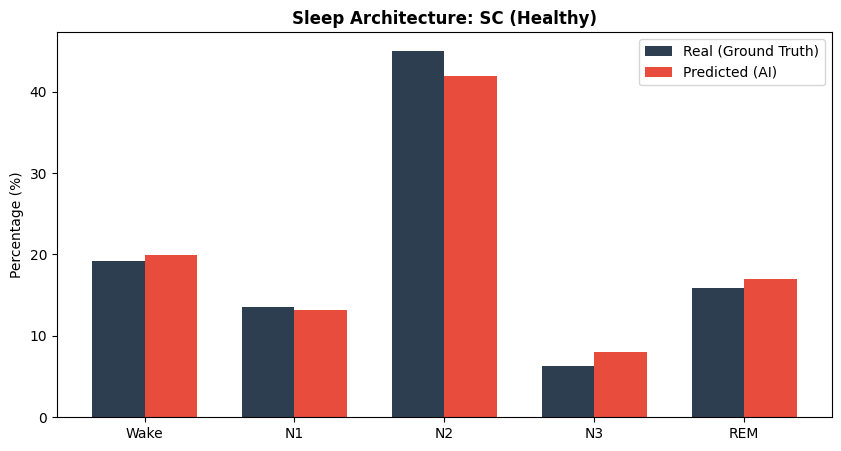

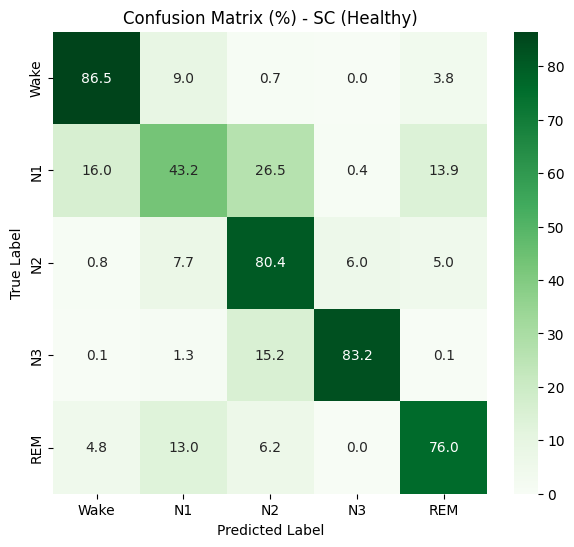

Loading 7 files for subset: ST...

ANALYZING SUBSET: ST (Temazepam Study)

Accuracy for ST (Temazepam Study): 81.26%
              precision    recall  f1-score   support

        Wake       0.79      0.76      0.77       617
          N1       0.47      0.64      0.54       608
          N2       0.88      0.88      0.88      3395
          N3       0.87      0.71      0.79      1066
         REM       0.83      0.82      0.82      1149

    accuracy                           0.81      6835
   macro avg       0.77      0.76      0.76      6835
weighted avg       0.83      0.81      0.82      6835



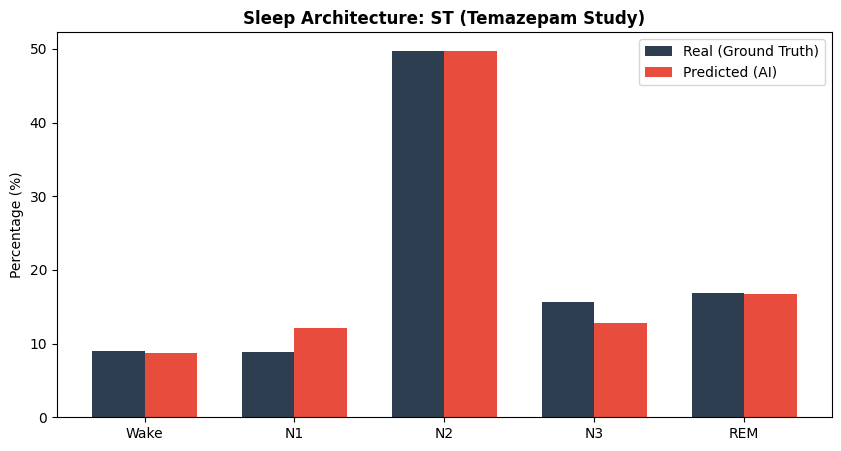

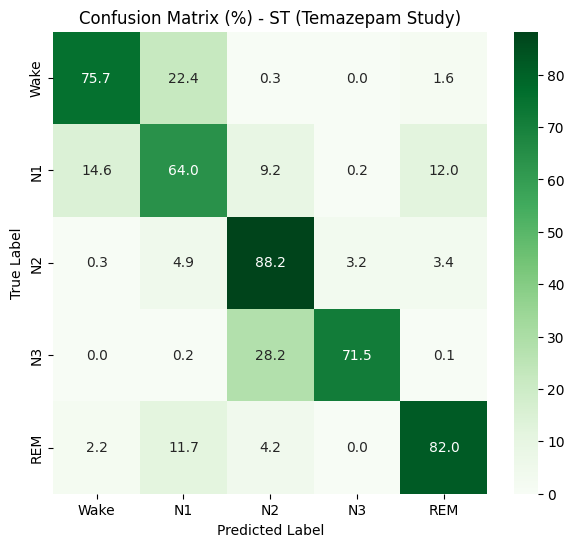

Loading 4 files for subset: UCD...

ANALYZING SUBSET: UCD (Apnea Patients)

Accuracy for UCD (Apnea Patients): 71.59%
              precision    recall  f1-score   support

        Wake       0.83      0.88      0.85       708
          N1       0.41      0.37      0.39       431
          N2       0.84      0.69      0.75      1371
          N3       0.87      0.72      0.79       463
         REM       0.54      0.83      0.65       585

    accuracy                           0.72      3558
   macro avg       0.70      0.70      0.69      3558
weighted avg       0.74      0.72      0.72      3558



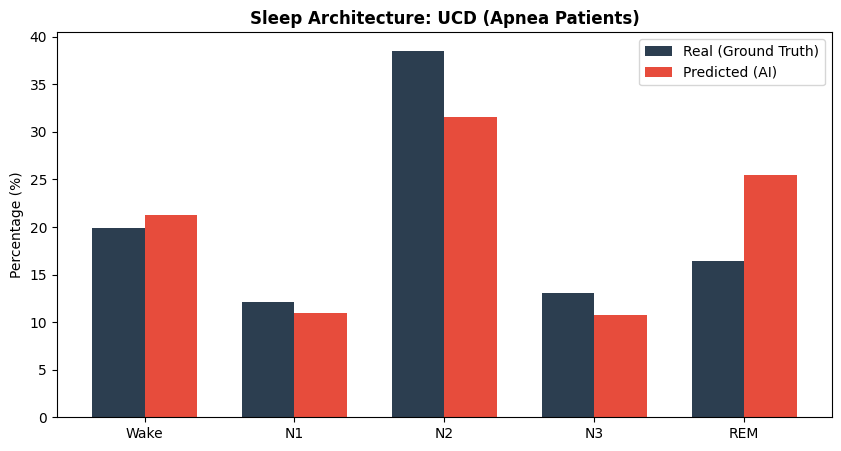

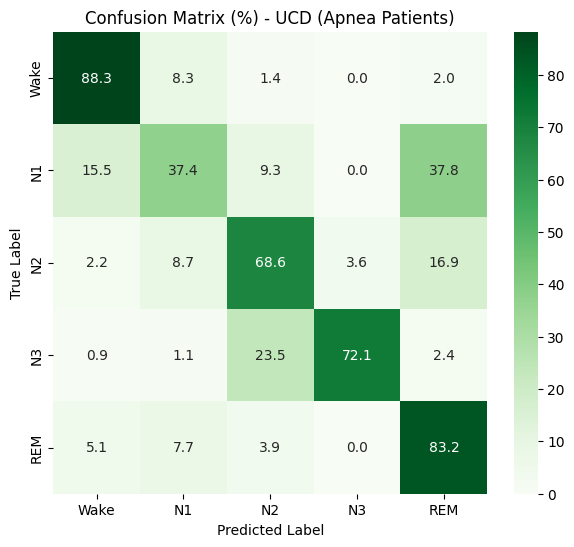

In [30]:
import torch
import numpy as np
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SPECIALIZED LOADER FOR SUBSETS ---
def get_filtered_test_loader(base_path, prefix, batch_size=32):
    """
    Loads only test files starting with a specific prefix (e.g., 'SC', 'ST', 'ucd').
    """
    folder = os.path.join(base_path, 'process_dataset', 'test')
    # Filter files by prefix
    file_list = [f for f in glob.glob(os.path.join(folder, "*.npz")) if os.path.basename(f).startswith(prefix)]

    if not file_list:
        print(f"No files found for prefix '{prefix}' in {folder}")
        return None

    print(f"Loading {len(file_list)} files for subset: {prefix.upper()}...")

    all_x = []
    all_y = []
    EXPECTED_LEN = 3000

    for f_path in file_list:
        try:
            with np.load(f_path) as f:
                raw_x = f['x']
                raw_y = f['y']

                # --- Dimension Logic (Same as before) ---
                if raw_x.ndim == 3 and raw_x.shape[2] == 1:   # UCD
                    x_extracted = raw_x[:, :, 0]
                elif raw_x.ndim == 3 and raw_x.shape[1] >= 1: # SC/ST
                    x_extracted = raw_x[:, 0, :]
                elif raw_x.ndim == 2:                         # Flat
                    x_extracted = raw_x
                else:
                    continue

                if x_extracted.shape[1] == EXPECTED_LEN:
                    all_x.append(x_extracted)
                    all_y.append(raw_y)
        except:
            continue

    if not all_x:
        return None

    # Concatenate
    X_data = np.concatenate(all_x)
    y_data = np.concatenate(all_y)

    # Convert to Tensor (N, 3000, 1)
    tensor_x = torch.tensor(X_data, dtype=torch.float32).unsqueeze(2)
    tensor_y = torch.tensor(y_data, dtype=torch.long)

    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# --- 2. ANALYSIS & PLOTTING FUNCTION ---
def run_analysis_for_subset(subset_name, loader, models, ensemble_weights, device):
    if loader is None: return

    print(f"\n{'='*60}")
    print(f"ANALYZING SUBSET: {subset_name}")
    print(f"{'='*60}")

    all_preds = []
    all_labels = []

    # Ensemble Prediction Loop
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Weighted Sum of Models
            final_out = torch.zeros(inputs.size(0), 5).to(device)
            valid_models = 0

            for i, model in enumerate(models):
                out = model(inputs)
                final_out += out * ensemble_weights[i]

            _, predicted = torch.max(final_out, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- A. Classification Report ---
    acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    print(f"\nAccuracy for {subset_name}: {acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- B. Sleep Architecture Comparison (Real vs Pred) ---
    total = len(all_labels)
    real_counts = [np.sum(np.array(all_labels) == i) for i in range(5)]
    pred_counts = [np.sum(np.array(all_preds) == i) for i in range(5)]

    real_pct = [c / total * 100 for c in real_counts]
    pred_pct = [c / total * 100 for c in pred_counts]

    # Bar Chart
    x = np.arange(len(class_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, real_pct, width, label='Real (Ground Truth)', color='#2c3e50')
    ax.bar(x + width/2, pred_pct, width, label='Predicted (AI)', color='#e74c3c')

    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Sleep Architecture: {subset_name}', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    plt.show()

    # --- C. Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    # Normalize to percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (%) - {subset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. EXECUTION ---
# Definim prefixurile pentru cele 3 seturi de date
subsets = [
    ("SC (Healthy)", "SC"),
    ("ST (Temazepam Study)", "ST"),
    ("UCD (Apnea Patients)", "ucd")
]

# Presupunem că variabila 'models' este încărcată din pasul anterior
# Dacă nu, trebuie reîncărcată (vezi codul anterior)
if 'models' not in locals() or not models:
    print("Models not loaded! Please run the previous cell to load models.")
else:
    for name, prefix in subsets:
        # 1. Creăm loader temporar doar pentru acest subset
        subset_loader = get_filtered_test_loader(base_path, prefix, batch_size=32)

        # 2. Rulăm analiza
        run_analysis_for_subset(name, subset_loader, models, ensemble_weights, device)

        # 3. Curățăm memoria
        del subset_loader
        torch.cuda.empty_cache()

---
# Conclusions and Next Step

In this notebook we ...

The next step in the project is to start building the model architectures. We will start with [**...**]().